# Nvidia Stock Prediction 

One day, I was watching the stock market for day trading opportunities, and I came across an article that explained how decrease in crypto price led to decrease in price of GPUs. This would then lower the total revenue of Nvidia, which would probably decrease Nvidia's stock price since the investors would have less confidence in the company's growth. The vice versa would also be true: if crypto price increases, more GPUs will be required for higher profitability, which would then increase Nvidia's revenue as well its stock price.

It would be great to predict buy/sell signals of Nvidia stock with crypto price since stocks cannot be traded during a certain timeframe, (ex. weekend) while cryto can be traded 24/7. The goal of this project is to determine if we should either buy or sell Nvidia stock based on the Ethereum's price movement in the previous trading day. For example, we will explore if decrease in Ethererum price on Sunday will lead to decrease in Nvidia stock price on Monday. 

Then, we will create a random forest classifer to determine if our prediction is better with using only the Nvidia's historical stock price data. At the end, we will conclude with our findings, and go over some potential future items to improve our project.

<span style='color:red'> **Please note that this project is for fun, and I am not encouraging anyone to use this as an investing strategy.** </span>

***
## Our Method

Here are the steps we will follow:

1. Download historical Nvidia stock price & Ethereum price from Yahoo finance
2. Explore the data and setup the dataset to predict buy/sell signals of Nvidia
3. Predict the signals based on the price movement direction of Nvidia and Ethereum 
4. Create random forest classifier model to predict the signals based on Nvidia price alone
    - Setup a backtesting function
    - Improve the accuracy of the model
5. Compare the two models 

***
## Downloading Our Data

Our target data will have historical Nvidia stock price and Ethereum price starting from 01/01/2021 to today's date. I picked Ethereum as my target crypto simply because it is on my watchlist and is well-known to people, and also, I chose a specific starting period to eliminate the high volatility in the stock market caused by COVID-19.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc

In [2]:
today = date.today()

start_date ="2021-01-01"
end_date = today.strftime("%Y-%m-%d")

stock_data = yf.download("NVDA ETH-USD", start=start_date, end=end_date)

[*********************100%***********************]  2 of 2 completed


***
## Exploring the Data

We have one row of data for each day that stocks were traded. Here are the columns:

- **Adj Close**: amended closing price to reflect any corporate actions
- **Close**: the closing price on the day
- **High**: the highest price during the day
- **Low**: the lowest price during the day
- **Open**: the price the stock opened at
- **Volume**: how many shares were traded

Note that some dates are missing because Nvidia stock does not trade every day (the market is closed on the weekends and holidays), but since crypto can be traded 24/7, we should not have any missing data for Ethereum (you might need to wait a day for update in Yahoo finance)

In [3]:
stock_data.tail(5)

Adj Close                    Close                     High  \
                ETH-USD        NVDA      ETH-USD        NVDA      ETH-USD   
Date                                                                        
2022-07-13  1113.587158  151.639999  1113.587158  151.639999  1113.587158   
2022-07-14  1191.526245  153.720001  1191.526245  153.720001  1202.953369   
2022-07-15  1233.129150  157.619995  1233.129150  157.619995  1275.778198   
2022-07-16  1352.626465         NaN  1352.626465         NaN  1377.944580   
2022-07-17  1339.181885         NaN  1339.181885         NaN  1377.281860   

                                Low                     Open              \
                  NVDA      ETH-USD        NVDA      ETH-USD        NVDA   
Date                                                                       
2022-07-13  153.750000  1019.220337  144.649994  1038.186646  145.899994   
2022-07-14  154.729996  1077.405762  147.279999  1113.515747  151.080002   
2022-07-15  157.820007  1182.903198  154.449997  1191.674805  156.589996   
2022-07-16         NaN  1195.605957         NaN  1232.791626         NaN   
2022-07-17         NaN  1331.006592         NaN  1355.447510         NaN   

                 Volume              
                ETH-USD        NVDA  
Date                                 
2022-07-13  18302588147  52191800.0  
2022-07-14  16688640823  45623500.0  
2022-07-15  17411448225  38447100.0  
2022-07-16  18364013796         NaN  
2022-07-17  16892382208         NaN

We will only include *Adj Close* in our data since it would be most accurate price to work with.

In [4]:
stock_data = stock_data[[("Adj Close", "ETH-USD"), ("Adj Close", "NVDA")]]
stock_data.columns = stock_data.columns.droplevel(0)
stock_data = stock_data.rename_axis(None, axis=1)
stock_data.tail(5)

,ETH-USD,NVDA
Date,,
2022-07-13,1113.587158,151.639999
2022-07-14,1191.526245,153.720001
2022-07-15,1233.129150,157.619995
2022-07-16,1352.626465,NaN
2022-07-17,1339.181885,NaN


***
## Correlation Between Ethereum and Nvidia

Now, we will calculate Pearson's correlation coefficient to measure the strength and direction of the relationship between Ethereum and Nvidia.

In [5]:
corr_data = stock_data.dropna()
correlation = corr_data.corr(method="pearson")
correlation

,ETH-USD,NVDA
ETH-USD,1.000000,0.786875
NVDA,0.786875,1.000000


Since our coefficient is greater than 0.70, we can conclude that the relationship between our target variables is statistically significant. 

Note that the coefficient could change over time, and if the result is not statistically significant, then we may need to take a different approach.

***
## Visualizing the Data

We will plot a graph for our data, but we will first normalize the prices to compare them at the same level. Otherwise, our visual comparison will be inaccurate because Ethereum price is much higher than Nvidia stock price.

By looking at our plot, we can see that two graphs tend to overlap with each other, implying that Ethereum price and Nvidia stock price move in a similar direction. Hence, we could deduce that if Ethereum price decreases on Sunday, Nvidia stock price will likely to decrease on Monday when the market opens.

In addition, observe that the Nvidia graph is discontinuous due to the missing data.

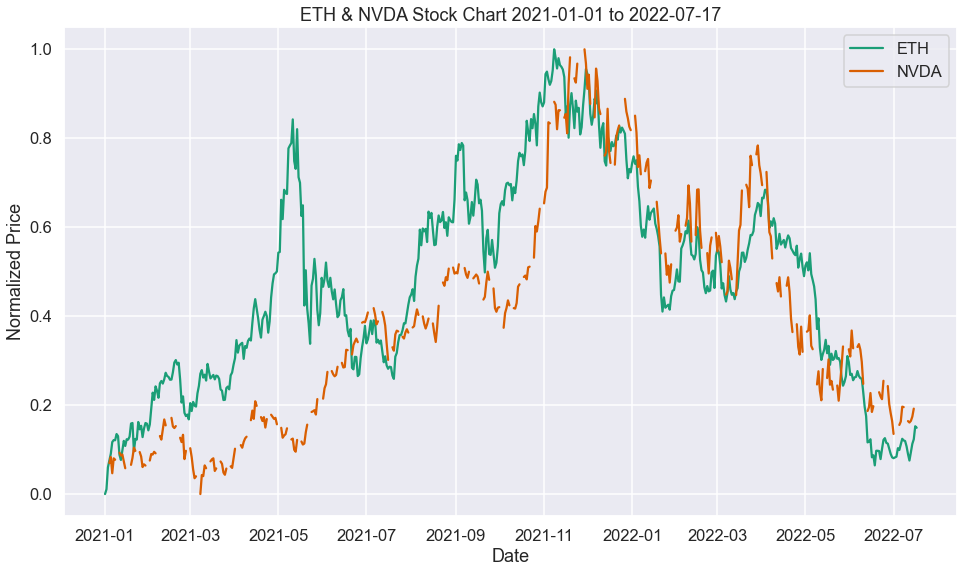

In [6]:
scaler = MinMaxScaler()

ETH_data, NVDA_data = stock_data["ETH-USD"].values, stock_data["NVDA"].values
ETH_data, NVDA_data = ETH_data.reshape(-1, 1), NVDA_data.reshape(-1, 1)

norm_ETH, norm_NVDA = scaler.fit_transform(ETH_data), scaler.fit_transform(NVDA_data)


sns.set(style='darkgrid', context='talk', palette='Dark2')
fig, ax = plt.subplots(figsize=(16,9))

ax.set_xlabel("Date")
ax.set_ylabel("Normalized Price")
ax.set_title(f"ETH & NVDA Stock Chart {start_date} to {end_date}")

ax.plot(stock_data.index, norm_ETH, label="ETH")
ax.plot(stock_data.index, norm_NVDA, label="NVDA")
ax.legend()

***
## Determining Price Movement Direction

Now, we will create *Prev Close* columns for both Ethereum and Nvidia such that we can calculate the percent change of each price based on previous adjusted closing price. 

Then, we will use a very simple formula for our percent change column:

$$
\frac{Price_{today} - Price_{yesterday}}{Price_{yesterday}} \cdot 100\%
$$

In [7]:
for column in stock_data.columns:
    stock_data[f"{column} Prev Close"] = stock_data[f"{column}"].shift(1)
    stock_data[f"{column} % Change"] = ((stock_data[f"{column}"] / stock_data[f"{column} Prev Close"]) - 1) * 100

stock_data.tail(5)

,ETH-USD,NVDA,ETH-USD Prev Close,ETH-USD % Change,NVDA Prev Close,NVDA % Change
Date,,,,,,
2022-07-13,1113.587158,151.639999,1038.191650,7.262196,150.820007,0.543689
2022-07-14,1191.526245,153.720001,1113.587158,6.998921,151.639999,1.371671
2022-07-15,1233.129150,157.619995,1191.526245,3.491564,153.720001,2.537076
2022-07-16,1352.626465,NaN,1233.129150,9.690576,157.619995,NaN
2022-07-17,1339.181885,NaN,1352.626465,-0.993961,NaN,NaN


Here, We will plot our percent change columns, and we can observe that there are overlaps with the graphs. 

This suggests us that Ethereum and Nvidia price tend move in a same direction: if Ethereum price goes up then Nvidia price will go up as well. 

In addition, Ethereum has higher price volatility than Nvidia stock, but we only care about the direction of the price movement instead of how much it increased/decreased.

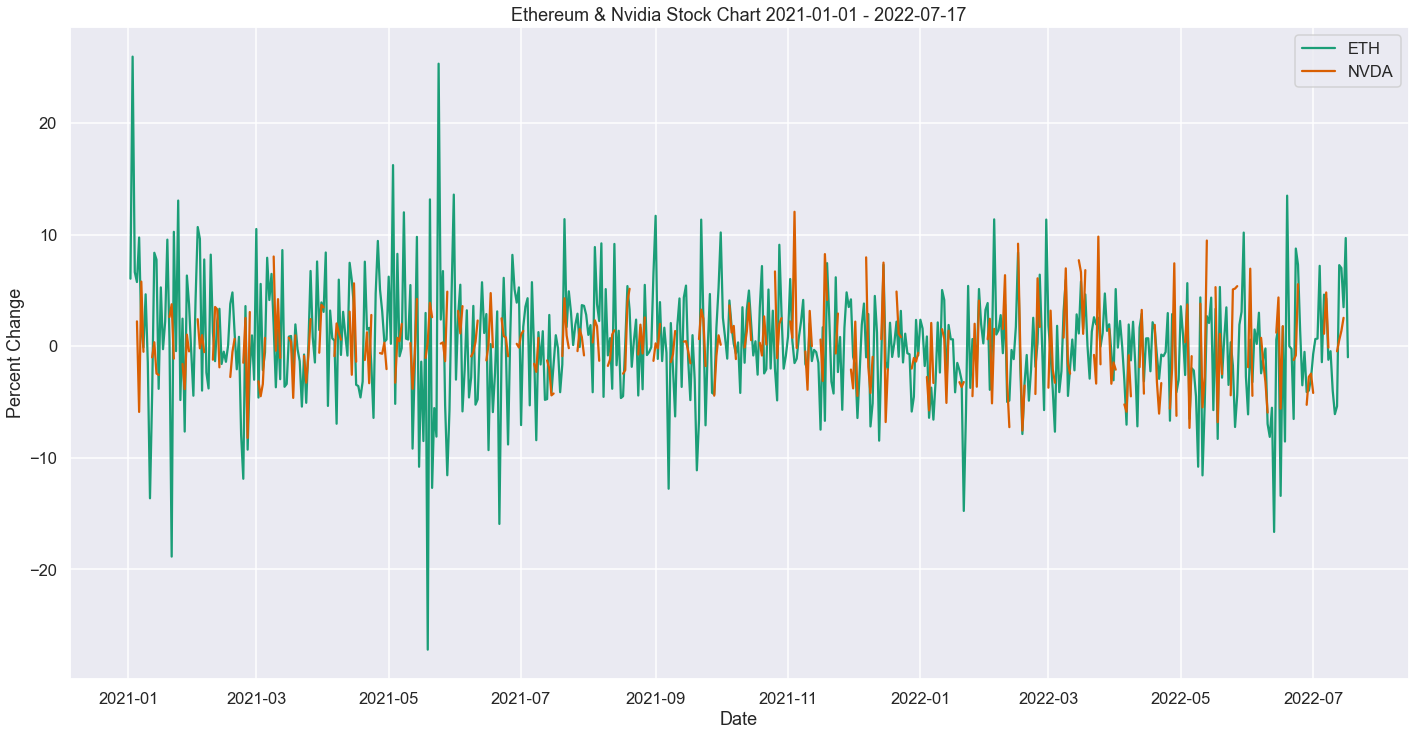

In [8]:
# Plots percent change of ETH and NVDA price

fig2, ax2 = plt.subplots(figsize=(24,12))

ax2.set_xlabel("Date")
ax2.set_ylabel("Percent Change")
ax2.set_title(f"Ethereum & Nvidia Stock Chart {start_date} - {end_date}")

ax2.plot(stock_data.index, stock_data['ETH-USD % Change'], label="ETH")
ax2.plot(stock_data.index, stock_data["NVDA % Change"], label="NVDA")
ax2.legend()

Based on percent change columns of our target variables, we will create an indicator column to quantify Nvidia stock and Ethereum price movement direction. The column will have 1 to indicate *yes* if the numerical signs (+ or -) of percent change correspond to each other and 0 to indicate *no* otherwise.

In [9]:
indicator_data = stock_data.copy()
indicator_data.dropna(inplace=True)
indicator_data["Indicator"] = np.where(np.sign(indicator_data["ETH-USD % Change"]) == np.sign(indicator_data["NVDA % Change"]), 1, 0)
indicator_data.tail(5)

,ETH-USD,NVDA,ETH-USD Prev Close,ETH-USD % Change,NVDA Prev Close,NVDA % Change,Indicator
Date,,,,,,,
2022-07-08,1222.506226,158.380005,1237.593384,-1.219072,158.580002,-0.126117,1
2022-07-12,1038.191650,150.820007,1097.236572,-5.381239,151.520004,-0.461983,1
2022-07-13,1113.587158,151.639999,1038.191650,7.262196,150.820007,0.543689,1
2022-07-14,1191.526245,153.720001,1113.587158,6.998921,151.639999,1.371671,1
2022-07-15,1233.129150,157.619995,1191.526245,3.491564,153.720001,2.537076,1


Using our indicators, we will caluate a ratio to determine if the prices tend to move in a same direction:

$$
\frac{\sum I_1}{\sum I_1 + \sum I_0}
$$

where *I* is our indicator variable.

In [10]:
ratio = indicator_data["Indicator"].sum() / len(indicator_data.index)
print(f"Correct Prediction (%): {round(ratio, 4)*100}")

Correct Prediction (%): 67.54


The ratio suggests us that Ethereum and Nvidia stock price do tend to move together. Hence, if Ethereum price goes up on Sunday, then we could make a buy order of Nvidia stock on Sunday and make some profit by selling it on Monday since Nvidia stock will likely to go up as well.

***
## Random Forest Classification

Now, we will predict Nvidia stock price using random forest classifer but without the Ethereum price data. Since we are not measuring the price movement of two target variables, we can use Nvidia historical data such that we can predict buy/sell signal for the stock even during the recession (such as COVID-19).

For convenience, we will re-download the Nvidia stock data, and similarly, we will only work with *Adj Close* column for now.

In [11]:
rf_data = yf.download("NVDA")
rf_data = rf_data[["Adj Close"]]

[*********************100%***********************]  1 of 1 completed


We will create a signal column that is based on previous day *Adj close* price. The method is similar to what we did with the indicator column: we want to buy the stock if we know that the stock price will go up the next day.

Our column will have 1 to signal *buy* and 0 to signal *sell*, and this will later help us to predict buy/sell signals for future data.

In [12]:
rf_data = rf_data.copy()
rf_data["Prev Close"] = rf_data.shift(1)
rf_data = rf_data.iloc[1:]

rf_data.dropna(inplace=True)
rf_data["Signal"] = np.where(rf_data["Adj Close"] > rf_data["Prev Close"], 1, 0)
rf_data.tail(5)

,Adj Close,Prev Close,Signal
Date,,,
2022-07-11,151.520004,158.380005,0
2022-07-12,150.820007,151.520004,0
2022-07-13,151.639999,150.820007,1
2022-07-14,153.720001,151.639999,1
2022-07-15,157.619995,153.720001,1


Here, we will leave 100 days of our stock data as a test set.

In [13]:
train_set, test_set = rf_data[:-100], rf_data[-100:]
X_train, X_test = train_set["Adj Close"].values.reshape(-1,1), test_set["Adj Close"].values.reshape(-1,1)
y_train, y_test = train_set["Signal"], test_set["Signal"]

Before we use the random forest classifier to generate our prediction on buy/sell signal, let's tune the hyperparameters to improve the accuracy of our model. We will primarily work on *n_estimators* and *min_samples_split*.

We will start by plotting a ROC curve to determine what parameter we should use for the best performance.

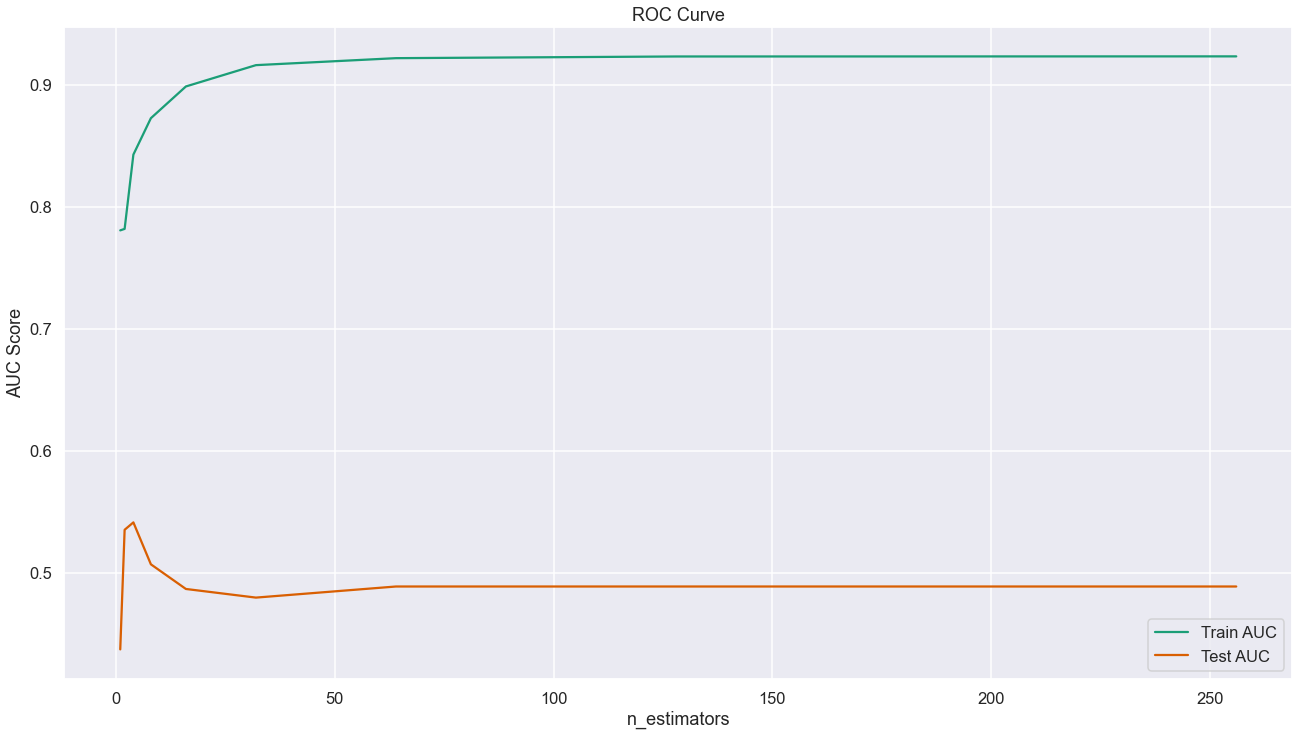

In [14]:
estimators = [1, 2, 4, 8, 16, 32, 64, 128, 256]

train_estimators = {}
test_estimators = {}

for estimator in estimators:
    model = RandomForestClassifier(n_estimators=estimator, 
                                   random_state=1, 
                                   n_jobs=-1)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_estimators[estimator] = roc_auc
    
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_estimators[estimator]= roc_auc


fig3, ax3 = plt.subplots(figsize=(22,12))

ax3.set_xlabel("n_estimators")
ax3.set_ylabel("AUC Score")
ax3.set_title("ROC Curve")

ax3.plot(estimators, list(train_estimators.values()), label="Train AUC")
ax3.plot(estimators, list(test_estimators.values()), label="Test AUC")
ax3.legend()

We can observe that the train AUC score increases as we increase the *n_estimators*, but however, the test AUC score decreases if we increase the number of *n_estimators*. As a result, we would probably use either 2 or 4 as our *n_estimators* parameter.

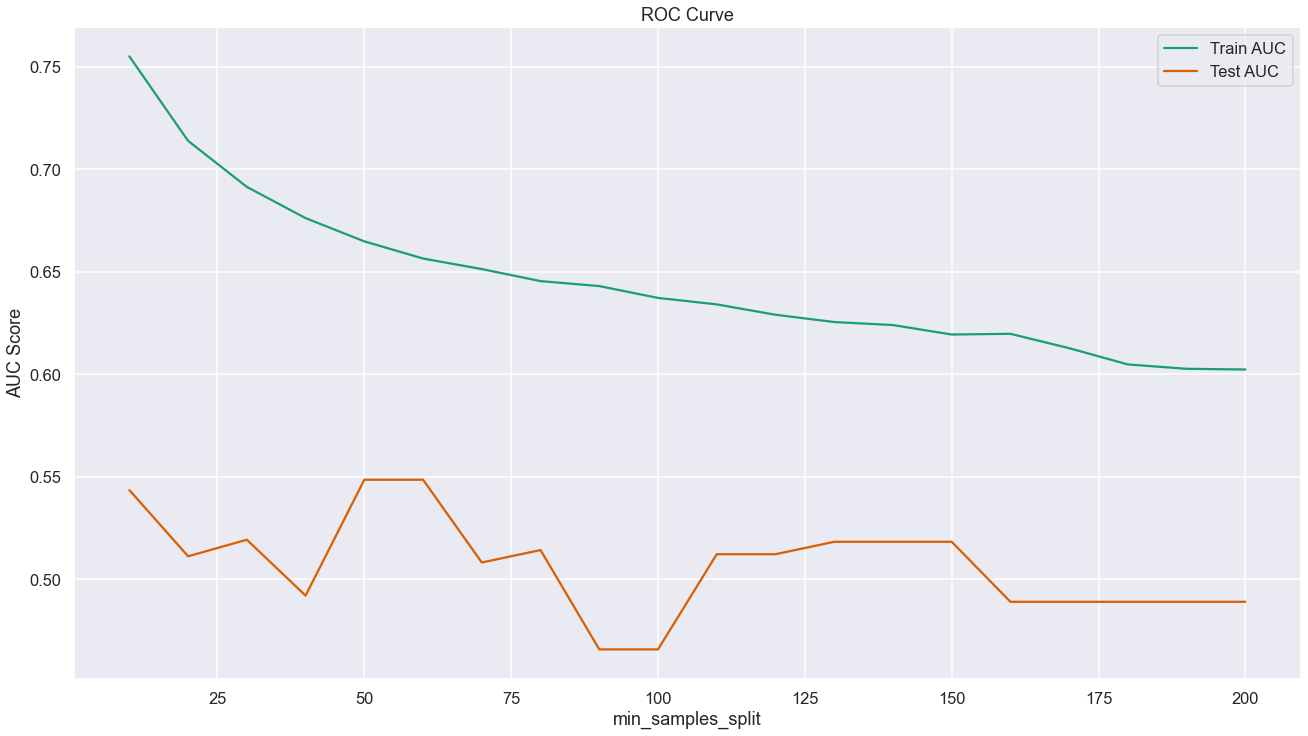

In [15]:
min_samples_split = [x for x in range(10, 201, 10)]

train_split = {}
test_split = {}

for split in min_samples_split:
    model = RandomForestClassifier(max(test_estimators, key=test_estimators.get), 
                                   min_samples_split=split, 
                                   random_state=1, 
                                   n_jobs=-1)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_split[split] = roc_auc
    
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_split[split]= roc_auc

fig4, ax4 = plt.subplots(figsize=(22,12))

ax4.set_xlabel("min_samples_split")
ax4.set_ylabel("AUC Score")
ax4.set_title("ROC Curve")

ax4.plot(min_samples_split, list(train_split.values()), label="Train AUC")
ax4.plot(min_samples_split, list(test_split.values()), label="Test AUC")
ax4.legend()

For the *min_samples_split* ROC curve, we observe that the train AUC score is decreasing as we increase the number of *min_sample_split* whereas the test score AUC varies. Just by looking at the graph, we can probably use 20 as our *min_samples_split*.

Now, we can use these tuned hyperparameters for our random forest model to predict buy/sell signals for Nvidia stock.

Correct Prediction (%): 53.0


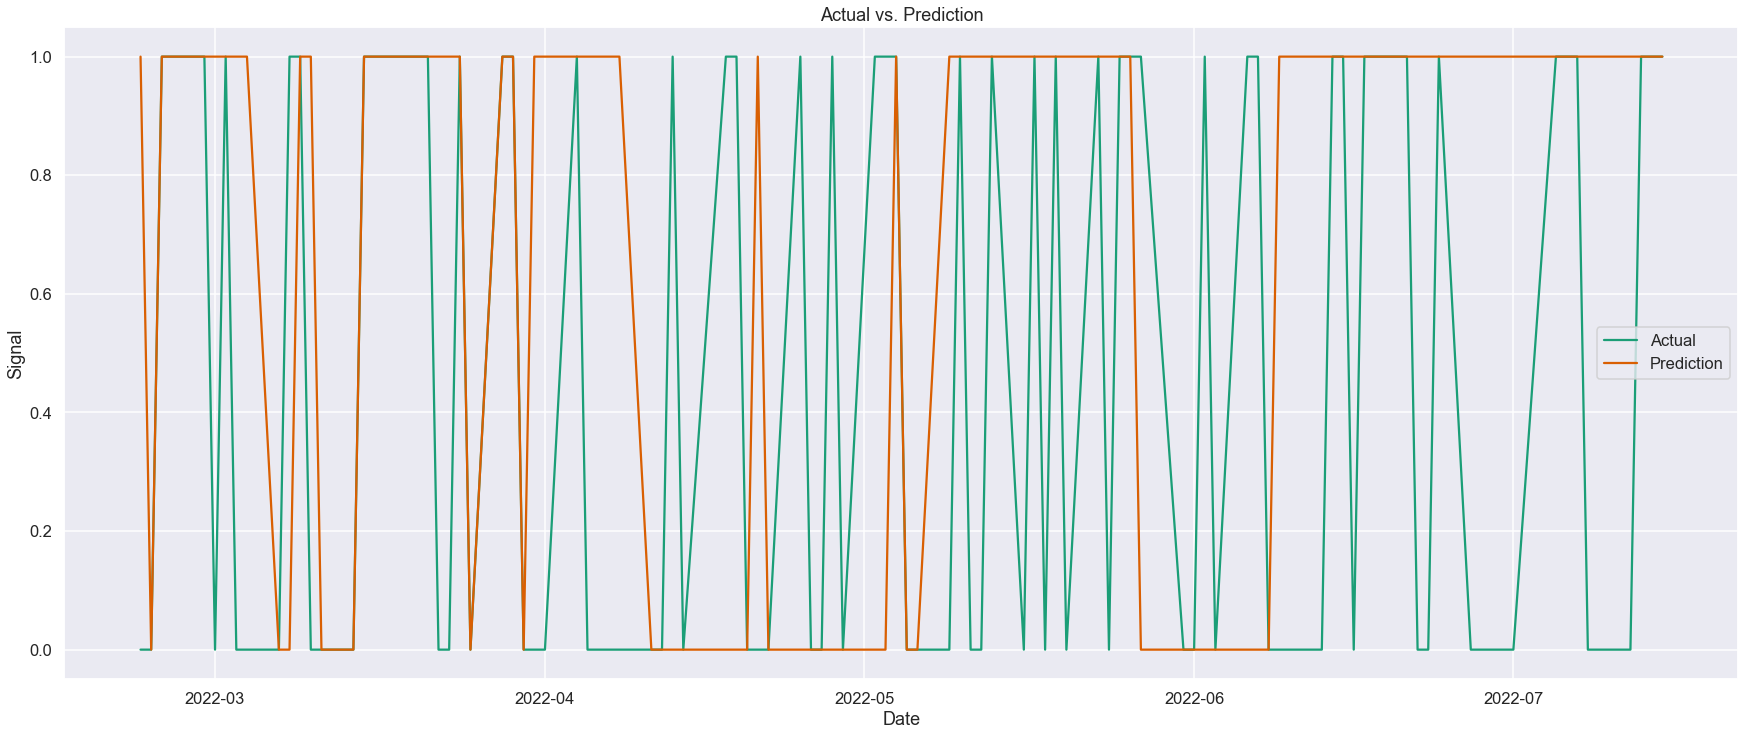

In [16]:
# Predicting our signal with the parameter
model = RandomForestClassifier(n_estimators=max(test_estimators, key=test_estimators.get), 
                               min_samples_split=max(test_split, key=test_split.get), 
                               random_state=1)
model.fit(X_train, y_train)

# Evaluate error of predictions

y_pred = model.predict(X_test)
y_true = np.array(y_test)

# Plotting against our predicted value and actual value

fig4, ax4 = plt.subplots(figsize=(30,12))

ax4.set_xlabel("Date")
ax4.set_ylabel("Signal")
ax4.set_title("Actual vs. Prediction")

ax4.plot(test_set["Signal"], label="Actual")
ax4.plot(pd.Series(y_pred, test_set.index), label="Prediction")
ax4.legend()

print(f"Correct Prediction (%): {round(accuracy_score(y_true, y_pred, normalize=True)*100,4)}")

Sadly, it turns out that our predictive model does little better than a coin flip. With this strategy, we might end up with a big loss. This suggests that we should rather rely on the price movement ratio. Nevertheless, as data scientists, we should always strive to improve the performance of our model. Let's explore some additional features we could use.

## Improving the Model

In [17]:
def backtest(data, model, features, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        X_train, X_test = train[features], test[features]
        y_train, y_test = train["Signal"], test["Signal"]
    
        # Fit the random forest model
        model.fit(X_train, y_train)

        # Make predictions
        preds = model.predict_proba(X_test)[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > 0.6] = 1
        preds[preds <= 0.6] = 0

        # Combine predictions and test values
        combined = pd.concat({"Signal": y_test,"Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)

In [18]:
# Note that signal is the only feature for now.

features = ["Adj Close"]

predictions = backtest(rf_data, model, features)
y_pred = predictions["Predictions"]
y_true = predictions["Signal"]

In [19]:
print(f"Correct Prediction (%): {round(accuracy_score(y_true, y_pred, normalize=True)*100,4)}")

Correct Prediction (%): 51.9258


In [20]:
# More features that indicate trends

weekly_mean = rf_data.rolling(7).mean()["Adj Close"]
quarterly_mean = rf_data.rolling(90).mean()["Adj Close"]
annual_mean = rf_data.rolling(365).mean()["Adj Close"]

rf_data["weekly_mean"] = weekly_mean / rf_data["Adj Close"]
rf_data["quarterly_mean"] = quarterly_mean / rf_data["Adj Close"]
rf_data["annual_mean"] = annual_mean / rf_data["Adj Close"]
rf_data["annual_weekly_mean"] = rf_data["annual_mean"] / rf_data["weekly_mean"]
rf_data["annual_quarterly_mean"] = rf_data["annual_mean"] / rf_data["quarterly_mean"]

In [21]:
# Let's include more features that we created

full_features = features + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean"]

full_predictions = backtest(rf_data.iloc[365:], model, full_features)
y_pred = full_predictions["Predictions"]
y_true = full_predictions["Signal"]

In [22]:
print(f"Correct Prediction (%): {round(accuracy_score(y_true, y_pred, normalize=True)*100,4)}")

Correct Prediction (%): 64.5531


***
## Conclusion